<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/SIR_mode_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

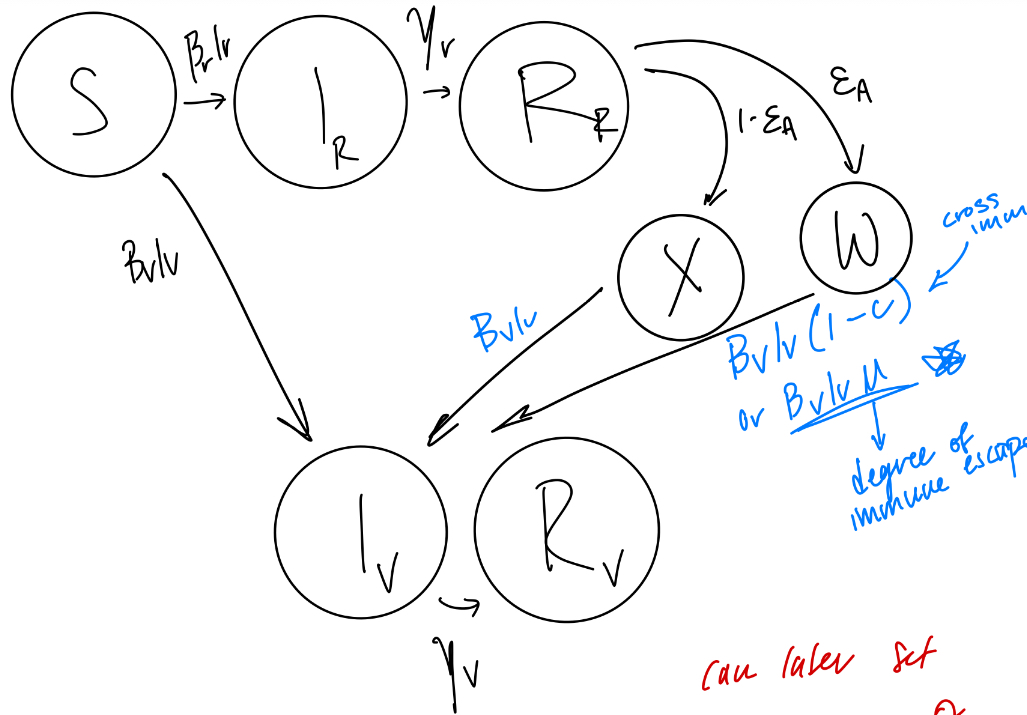

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r S - \gamma_r I_r$

$\frac{\mathrm{d}R_r}{\mathrm{d}t} = \gamma_rI_r - R_r$


$\frac{\mathrm{d}X}{\mathrm{d}t} = (1-\epsilon_a)R_r - \beta_v I_v X$

$\frac{\mathrm{d}W}{\mathrm{d}t} = \epsilon_aR_r - \beta_v I_v (\mu) W$


$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v S + \beta_v I_v X + \beta_v I_v (\mu) - \gamma_v I_v$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \gamma_v I_v$

CHANGE N AND P TO X AND Y


In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [103]:
# SIR model equations
def SIR_model_rv(t, y, mu, betar, gammar, betav, gammav, epsilona):
    S, Ir, Rr, X, W, Iv, Rv,  = y
    dSdt = -(betar*Ir + betav*Iv) * S
    dIrdt = betar * Ir * S - gammar * Ir
    dRrdt = gammar * Ir - Rr

    dXdt = (1-epsilona)*Rr - betav*Iv*X
    dWdt = epsilona * Rr - betav*Iv*mu*W

    dIvdt = betav*Iv*S + betav*Iv*X + betav*Iv*mu*W - gammav * Iv
    dRvdt = gammav * Iv

    return [dSdt, dIrdt, dRrdt, dXdt, dWdt, dIvdt, dRvdt]

In [104]:
# set parameter values
Rrnaught = 4
gammar = 1/14
betar = Rrnaught * gammar

Rvnaught = 4
gammav = 1/14
betav = Rvnaught * gammav

mu = 0.2
epsilona = 0.5
t = 500

# set initial conditions
S0 = 0
Ir0 = 0
Rr0 = 0.99

X0 = 0
W0 = 0

Rv0 = 0
Iv0 = 1-(S0+Rr0+Ir0+X0+W0+Rv0) #need to get this seeded later


if (S0+Rr0+Ir0+Iv0+Rv0+X0+W0) != 1 or Iv0 < 0:
  print("Parameters don't add up to 1 or there are negative parameter values")

y0 = [S0, Ir0, Rr0, X0, W0, Iv0, Rv0]

# Solve the SIR model equations using odeint()
solution = solve_ivp(SIR_model_rv,
                     [0,t],
                     y0,
                     args=(mu, betar, gammar, betav, gammav, epsilona),
                     dense_output=True,
                     t_eval=np.linspace(0, t, t + 1),)



ODEINT VS SOLVE IVP


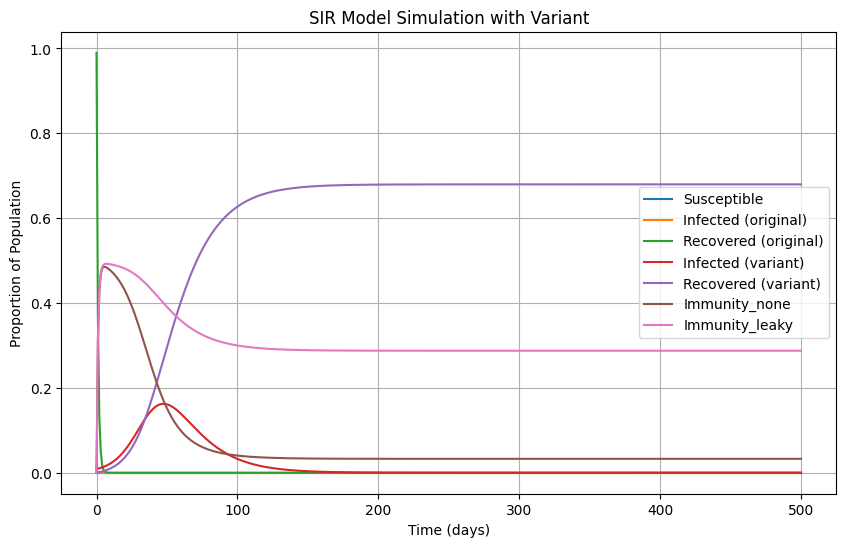

In [105]:
# Extract time and solution arrays
t = solution.t
S, Ir, Rr, X, W, Iv, Rv = solution.y

plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, Ir, label='Infected (original)')
plt.plot(t, Rr, label='Recovered (original)')
plt.plot(t, Iv, label='Infected (variant)')
plt.plot(t, Rv, label='Recovered (variant)')
plt.plot(t, X, label='Immunity_none')
plt.plot(t, W, label='Immunity_leaky')

plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model Simulation with Variant')
plt.legend()
plt.grid(True)
plt.show()
